# 04: Thunderstorm Wind Average Magnitude Forecast | Region: U.S. Midwest
---

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from datetime import datetime

pd.set_option('display.max_columns', None)

---
## 2. Loading Data

In [2]:
all_storms = pd.read_csv('../data/all_storms_dt_damage_clean.csv')

/Applications/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


---
## 3. Organizing Data

### 3.1. Dropping Columns

In [3]:
all_storms = all_storms[['state', 'region', 'event_type', 'begin_date_time', 'magnitude']]

In [4]:
all_storms

,state,region,event_type,begin_date_time,magnitude
0,Oklahoma,South,Tornado,1950-04-28 14:45:00,0.0
1,Texas,South,Tornado,1950-06-19 20:40:00,0.0
2,Indiana,Midwest,Tornado,1950-07-19 14:30:00,0.0
3,Indiana,Midwest,Tornado,1950-07-19 17:45:00,0.0
4,Colorado,West,Tornado,1950-07-22 15:07:00,0.0
...,...,...,...,...,...
1740591,Arkansas,South,Winter Storm,2022-02-02 18:45:00,NaN
1740592,Arkansas,South,Winter Weather,2022-02-03 02:50:00,NaN
1740593,Arkansas,South,Winter Storm,2022-02-03 01:00:00,NaN
1740594,Massachusetts,Northeast,Heavy Snow,2022-02-25 00:00:00,NaN


In [5]:
# Casting the BEGIN_DATE_TIME to a datetime dtype
all_storms['begin_date_time'] = pd.to_datetime(all_storms['begin_date_time'])

# Setting begin_date_time as the index
all_storms.set_index('begin_date_time', inplace=True)

# Sorting the index
all_storms.sort_index(inplace=True)

In [6]:
# Dropping all rows with a missing value in the magnitude column

all_storms = all_storms.dropna(subset=['magnitude'])

### 3.2. Subsetting to Thunderstorm Wind in the Midwest (1996-2022)

In [7]:
ts_wind = all_storms[all_storms['event_type'] == 'Thunderstorm Wind']

ts_wind = ts_wind[ts_wind['region'] == 'Midwest']

ts_wind = ts_wind[ts_wind.index > '1996']

In [8]:
ts_wind

,state,region,event_type,magnitude
begin_date_time,,,,
1996-01-18 02:00:00,Missouri,Midwest,Thunderstorm Wind,52.0
1996-01-18 07:20:00,Missouri,Midwest,Thunderstorm Wind,93.0
1996-01-18 08:15:00,Missouri,Midwest,Thunderstorm Wind,48.0
1996-01-18 09:30:00,Illinois,Midwest,Thunderstorm Wind,50.0
1996-01-18 09:45:00,Illinois,Midwest,Thunderstorm Wind,50.0
...,...,...,...,...
2022-03-30 18:17:00,Indiana,Midwest,Thunderstorm Wind,56.0
2022-03-30 18:25:00,Indiana,Midwest,Thunderstorm Wind,65.0
2022-03-30 19:35:00,Indiana,Midwest,Thunderstorm Wind,52.0


### 3.3. Resampling to Quarterly Averages

In [54]:
# Helper plotting function

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
   
    plt.figure(figsize=(10,6))
    
    for col in cols:
        plt.plot(df[col])

    plt.title(title, fontsize=14)
    plt.xlabel(xlab, fontsize=12)
    plt.ylabel(ylab, fontsize=12)
    
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12);

In [34]:
# Resampling to quarterly averages
ts_wind = ts_wind.resample('Q').mean()

# Renaming the column to 'avg_mag'
ts_wind = ts_wind.rename(columns={'magnitude': 'avg_mag'})

In [35]:
# Checking for null values as a result of the resampling

ts_wind.isnull().sum()

avg_mag    0
dtype: int64

In [37]:
ts_wind

,avg_mag
begin_date_time,
1996-03-31,53.722222
1996-06-30,57.791843
1996-09-30,56.887309
1996-12-31,54.502674
1997-03-31,56.605634
...,...
2021-03-31,58.866667
2021-06-30,55.734145
2021-09-30,55.036173


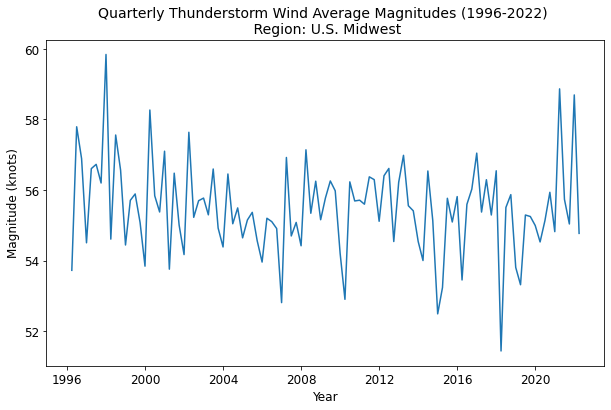

In [55]:
# Quarterly Thunderstorm Wind Average Magnitudes (1996-2022) - Region: U.S. Midwest

plot_series(ts_wind, ['avg_mag'], title='Quarterly Thunderstorm Wind Average Magnitudes (1996-2022) \n Region: U.S. Midwest', xlab='Year', ylab='Magnitude (knots)', steps=4)

---
## 4. Trends

### 4.1. Seasonality

For a better look at the trends and seasonality, I'll start with using the seasonal_decompose function. The breaks the times series down into the following 3 components:
- *Trend:* This describes whether a times series increases, decreases and remains constant over time.
- *Seasonality:* This removes trends from the data and attempts to describe periodic (seasonal) patterns.
- *Redsid:* This removes both trends and seasonality from the data and describes how much variability exists and therefore, how much can't be explained by the model.

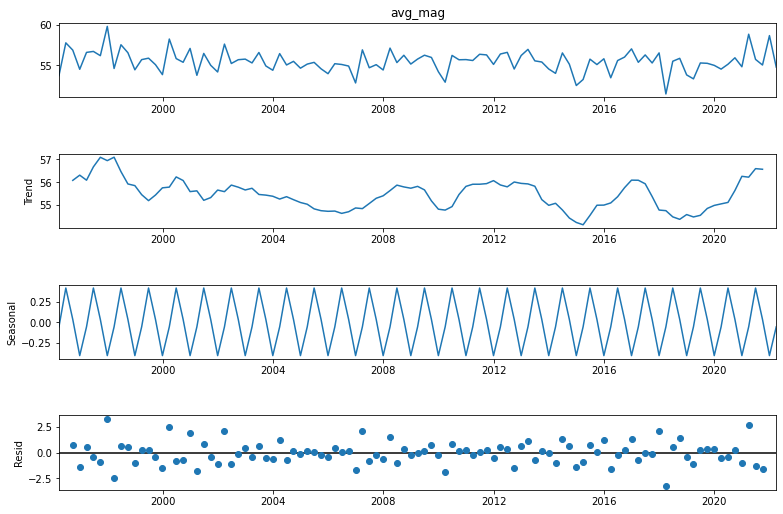

In [42]:
decomp = seasonal_decompose(ts_wind['avg_mag'])

decomp.plot();
fig = plt.gcf()
fig.set_size_inches(12, 8)

In the trend component, we see that the averages fluctuate quite a bit, and neither increase or decrease over time.

In the seasonal component, we see that there appears to be some seasonality detected. But this seasonal view can sometimes be misleading, so I'll need to run some additional diagnostics.

In the resid component, we see that there's quite a bit of variability that can not be explained by the model.

### 4.2. Autocorrelation

Autocorrelation here will refer to the correlation of the average magnitude variable with lagged versions of itself. This will be helpful in continuing to detect trends and seasonality. It will also be helpful in giving an idea of how many lags will be useful to include in the model for best results. I'll be using the default alpha of 0.05.

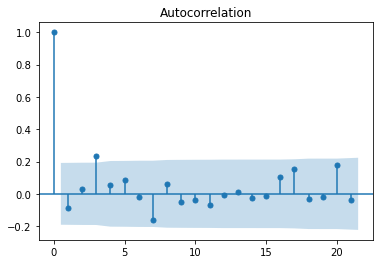

In [15]:
plot_acf(ts_wind['avg_mag']);

For trend, the lack of large and positive values in the earlier lags indicate and confirm that there is no existing trend in the data.

For seasonality, the fluctuations do not occur with a fixed and known frequency and therefore, indicates that there is no seasonality in the data.

For lags, it seems that not using any will lead to best results. If any are to be used, it's usually the first few, but they must extend beyond the blue region, which represents a 95% confidence interval, in order to have any statistical significance. Though the third lag does extend beyond the blue region, lags 1 and 2 would have also needed to extend beyond the blue region.

### 4.3. Partial Autocorrelation

Partial autocorrelation here also refers to the correlation of the average magnitude variable with lagged versions of itself. However, it also controls for all lower-lag autocorrelations. It serves as a final check in determining if there is seasonality present and how many lags will be useful to include in the model. Again,  I'll be using the default alpha of 0.05.

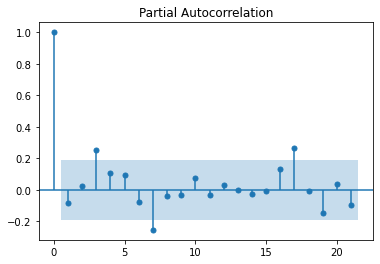

In [16]:
plot_pacf(ts_wind['avg_mag']);

For seasonality, as seen in the autocorrelation, the fluctuations do not occur with a fixed and known frequency and therefore, confirms that there is no seasonality present.

For lags, in addition to the 3rd lag, the 7th and 17th lag now also extend beyond the blue region, but this makes no difference as it's the first few lags the must extend beyond the blue region in order for later lags to even be considered. So it is confirmed that not using any lags will lead to the best results.

### 4.4. Stationarity

Because I'm working with univariate data and not bringing in exogenous variables, I'll be using the ARIMA model. This model requires the stationary data, meaning that there can't be any signs of trends or seasonality present. Through the autocorrelation and partial autocorrelation plots, I confirmed that there were no trends or seasonality present, but the Dickey-Fuller test will let me be absolutely certain. If the test tells me otherwise, then I'll need to replaces values with the difference between them and their previous values in order to ensure stationarity.

In [17]:
# Dickey-Fuller Stationarity Test

adfuller(ts_wind['avg_mag'])

(-11.08827087904591,
 4.143775115176037e-20,
 0,
 104,
 {'1%': -3.4948504603223145,
  '5%': -2.889758398668639,
  '10%': -2.5818220155325444},
 300.1822144908343)

The first 2 statistics of the test result tell me that the data is indeed already stationary and that no differencing is required. The first statistic is the 'test statistic'. This value needs to be less than the critial values, which are the 1%, 5% and 10% values, and it is. The second statistic is the p-value, which needs to be less than the alpha of 0.05, and it is.

---
## 5. ARIMA Time Series Modeling

### 5.1. Train-Test Split

Considering the few observations that I have to work with, I'll be using 90% of the data to train on.

In [18]:
y_train, y_test = train_test_split(ts_wind['avg_mag'], test_size=0.1, shuffle=False)

### 5.2. GridSearch for best AIC, p & q

The ARIMA model requires 3 parameters: p (the number of lags), d (the number of times the data needs to be differenced), and q (the size of the moving average window). Through the Dickey-Fuller Test, I've already established that the data does not require any differencing, so I know d=0. That leaves p and q. For p, based on the autocorrelation and partial autocorrelation plots, it doesn't seem that I'll need many, if any. And for q, I don't yet have an indication as to what this value would be. To find the optimal p and q, I'll run a manual GridSearch that will find the combination of p, d, and q that returns the lowest AIC (Akaike Information Criterion) score, given that d=0. The AIC score estimates the prediction error of a model, which is why I'll go with the combination that returns the lowest score.

In [19]:
best_aic = 1_000_000_000
best_p = 0
best_q = 0

for p in range(5):
    for q in range(5):

        try:
            
            arima = ARIMA(endog = y_train.astype(float).dropna(),
                         order=(p, 0, q))
            
            model = arima.fit(method_kwargs={"warn_convergence": False})

            print(f'The AIC for ARIMA({p},0,{q}) is: {model.aic}')

            if model.aic < best_aic:
                best_aic = model.aic
                best_p = p
                best_q = q

        except Exception as e:
            print(e)
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},0,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

The AIC for ARIMA(0,0,0) is: 319.05647654186953
The AIC for ARIMA(0,0,1) is: 320.63382433700633
The AIC for ARIMA(0,0,2) is: 322.3783772345771
The AIC for ARIMA(0,0,3) is: 317.7710107566079
The AIC for ARIMA(0,0,4) is: 316.18602322964244
The AIC for ARIMA(1,0,0) is: 320.6043113062053
The AIC for ARIMA(1,0,1) is: 322.5991131052841
The AIC for ARIMA(1,0,2) is: 320.0461103748888
The AIC for ARIMA(1,0,3) is: 316.8815756593033


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(1,0,4) is: 318.16148158297864
The AIC for ARIMA(2,0,0) is: 322.567874065449
The AIC for ARIMA(2,0,1) is: 322.21726975630827
The AIC for ARIMA(2,0,2) is: 315.35199744344794
The AIC for ARIMA(2,0,3) is: 316.60279921310905
The AIC for ARIMA(2,0,4) is: 318.59128211735265
The AIC for ARIMA(3,0,0) is: 320.24326357558647
The AIC for ARIMA(3,0,1) is: 320.56809625999335
The AIC for ARIMA(3,0,2) is: 316.63777841312196
The AIC for ARIMA(3,0,3) is: 318.5615075420145
The AIC for ARIMA(3,0,4) is: 320.55389268745756
The AIC for ARIMA(4,0,0) is: 320.5099830482291
The AIC for ARIMA(4,0,1) is: 322.1605301801779
The AIC for ARIMA(4,0,2) is: 318.62566679833344
The AIC for ARIMA(4,0,3) is: 320.538203562618
The AIC for ARIMA(4,0,4) is: 319.82148442295926


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(2,0,2).
This model has an AIC of 315.35199744344794.


The p, d, q combination that returned the lowest AIC was when p=2, d=0, and q=2. This means that the model will perform best with the use of 2 lags, no differencing and a moving average window of 2. This combination, referred to as an order,  will be referenced as (2,0,2) and will be used as the ARIMA model order parameter.

### 5.3. Instantiate & Fit

In [20]:
model = ARIMA(endog=y_train.astype(float).dropna(), order = (2,0,2))

arima = model.fit()

### 5.4. Test Forecast

In [43]:
# Checking how many quarters were considered as test data with a test size of 10%

len(y_test)

11

In [44]:
# Generating the forecast for those 11 quarters

forecast = arima.forecast(steps=11)
forecast

2019-09-30    55.585972
2019-12-31    55.408676
2020-03-31    55.336213
2020-06-30    55.369655
2020-09-30    55.444504
2020-12-31    55.497553
2021-03-31    55.505224
2021-06-30    55.481623
2021-09-30    55.454238
2021-12-31    55.441478
2022-03-31    55.445123
Freq: Q-DEC, Name: predicted_mean, dtype: float64

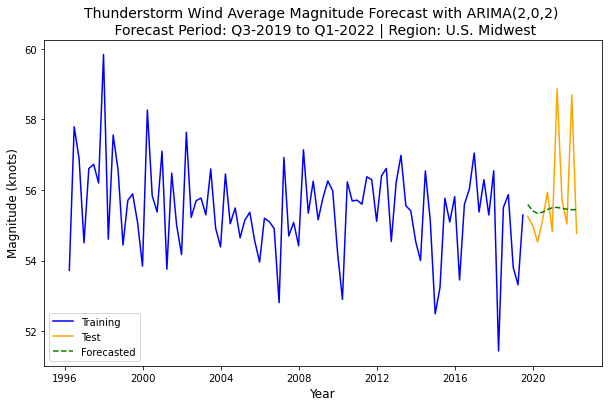

In [58]:
# Thunderstorm Wind Average Magnitude Forecast with ARIMA(2,0,2) - Forecast Period: Q3-2019 to Q1-2022 | Region: U.S. Midwest

plt.figure(figsize=(10,6))
plt.plot(y_train.index, y_train, color='blue', label='Training')
plt.plot(y_test.index, y_test, color='orange', label='Test')
plt.plot(y_test.index, forecast, color='green', label='Forecasted', linestyle='--')

plt.title(label = 'Thunderstorm Wind Average Magnitude Forecast with ARIMA(2,0,2) \n Forecast Period: Q3-2019 to Q1-2022 | Region: U.S. Midwest', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Magnitude (knots)', fontsize=12)

plt.legend();

Visually, the model does not seem to have forecasted very well. Instead of trying to follow the fluctuations, it went straight to predicting the mean. However, I'll make use of statistical evaluation metrics that will tell me exactly how the model performed.

### 5.5. Test Evaluation

To evaluate the forecast, I'll use the R2 score to explain how well the model explains the variability of the data, as well as the comparison of the root mean squared error and the standard deviation of the quarterly magnitude averages. The RMSE will describe how far off the forecasted values were from the actual values, and the standard deviation will indicate the amount of variability that is acceptable. So long as the root mean squared error does not exceed the standard deviation, we can infer the model has reasonable predictive power.

In [74]:
r2 = r2_score(y_test, forecast)
print('R2: ' + str(r2))

R2: -0.03588638980368164


The model does not do well at all in explaining the variability of the data, and is why the model went straight to forecasting the mean.

In [25]:
rmse = mean_squared_error(y_test, forecast, squared=False)
print('RMSE: ' + str(rmse))

RMSE: 1.485509440351035


In [61]:
ts_wind.describe()

,avg_mag
count,105.000000
mean,55.487117
std,1.321917
min,51.435897
25%,54.769874
50%,55.376190
75%,56.255628
max,59.841584


The RMSE of 1.49 exceeded the standard deviation of 1.32. This model's forecasts are not reliable by these evaluation metric's standards.